<a href="https://colab.research.google.com/github/DannyRoss123/AIXHW4/blob/main/HW4AIX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Interpretability Analysis Using PDP, ICE, and ALE Plots

For this homework assignment, I will explore model interpretability using three different visualization techniques: Partial Dependence Plots (PDP), Individual Conditional Expectation (ICE) plots, and Accumulated Local Effects (ALE) plots. I've chosen to work with the ResNet-34 model and CIFAR-10 dataset because they provide a good balance between complexity and interpretability. Before diving into the visualization techniques, I'll perform exploratory analysis to understand feature correlations within the dataset, focusing specifically on how pixel values in different color channels relate to each other. Through these visualizations, I aim to understand how different color channels and pixel intensities influence the model's predictions and examine any interesting patterns that emerge in the context of image classification.


In [2]:
!pip install alibi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.1/522.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 5.1 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: pillow 11.1.0
    Uninstalling pillow-11.1.0:
      Successfully uninstalled pillow-11.1.0
  Attempting uninstall: attrs
    Found existing installation: attrs 25.1.0
    Uninstalling attrs-25.1.0:
      Successfully uninstalled attrs-25.1.0
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.25.1
    Uninstalling scikit-image-0.25.1:
      Successfully uninstalled scikit-image-0.25.1


#Model Setup
To begin my analysis, I will first import all necessary libraries and set up the pre-trained ResNet34 model.

In [16]:
import torch
import torchvision
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from alibi.explainers import ALE, PartialDependence
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Download and set up pre-trained ResNet34
model = models.resnet34(pretrained=True)
model.eval()

print("Model loaded successfully!")   #Taken from previous assignment

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model loaded successfully!


#Image Preprocessing and Data Preparation
The next step is to set up our image preprocessing pipeline. For the ResNet34 model to properly analyze images, we need to apply several transformations to ensure the input data matches the model's requirements. These transformations include resizing the images to 256x256 pixels, center cropping to 224x224 pixels, converting the images to tensors, and normalizing them using the standard ImageNet mean and standard deviation values.

In [2]:
transform = transforms.Compose([
    transforms.Resize(256),          # Resize image to 256x256 pixels
    transforms.CenterCrop(224),      # Crop center to 224x224 pixels
    transforms.ToTensor(),           # Convert to tensor
    transforms.Normalize(            # Normalize with ImageNet mean and std
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


def preprocess_image(image_path):
    img = Image.open(image_path)

    # Apply transformations
    img_tensor = transform(img)

    # Add batch dimension
    img_tensor = img_tensor.unsqueeze(0)


    return img_tensor, img

print("Preprocessing function ready!")  #Taken from previous assignment

Preprocessing function ready!


#Dataset Loading and Preparation

Now, we need to load the CIFAR-10 dataset that we'll be using with our model. CIFAR-10 is a dataset consisting of 60,000 32x32 color images across 10 different classes. For our analysis, we'll use the test subset of the dataset to evaluate feature importance and model behavior. I'll set up a DataLoader with a small batch size to help us examine how the model interprets different images. The DataLoader will apply our previously defined transformations to each image, ensuring they're properly preprocessed for the ResNet34 model.

In [3]:
# Load CIFAR-10 dataset
test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# Create a dataloader
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=5,
    shuffle=True                           #Modified from Claude AI at 10:10 pm 2/4/2025
)

# Get one batch of images and try a prediction
images, labels = next(iter(test_loader))
outputs = model(images)

print(f"Image batch shape: {images.shape}")
print(f"Model output shape: {outputs.shape}")

100%|██████████| 170M/170M [00:02<00:00, 61.6MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Image batch shape: torch.Size([5, 3, 224, 224])
Model output shape: torch.Size([5, 1000])


#Feature Correlation Analysis
Now that we have loaded the dataset and tested it on the RESNET model, producing 1000 classes for the 1000 images, we can start using our evaluation techniques. Before diving into our model interpretation techniques, I want to explore how different features in our images relate to each other. I'll start by analyzing the correlations between the first 10 features - pixels from our flattened image - and calculating some basic statistics to better understand the patterns in our data.

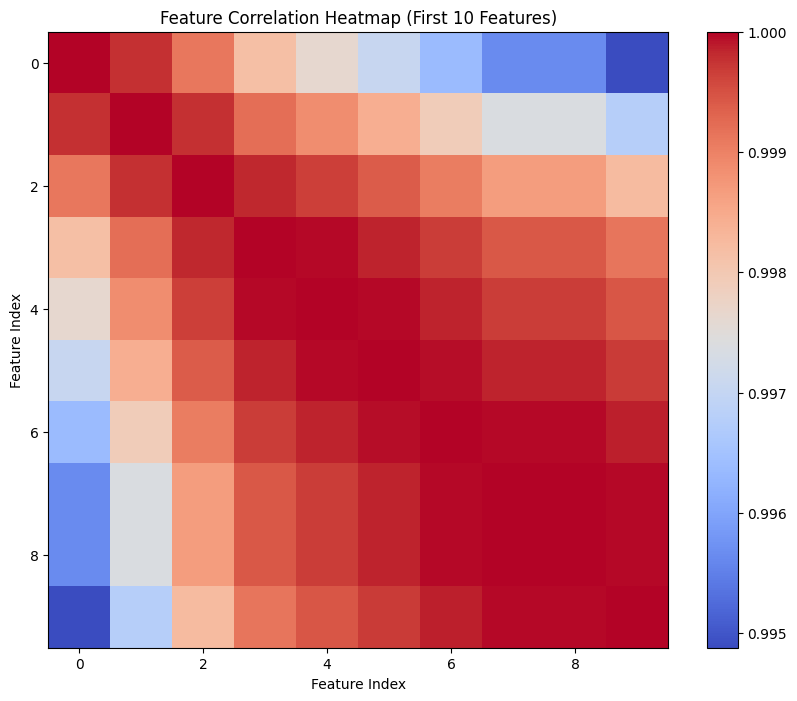


Feature Statistics:
Number of features per image: 150528
Range of values: -2.049 to 2.588
Mean value: 0.010
Standard deviation: 0.969


In [6]:
# Convert images to a format we can analyze
X = images.numpy()  # Convert from tensor to numpy
X = X.reshape(X.shape[0], -1)  # Flatten each image

# Calculate correlation matrix for first few features
num_features_to_analyze = 10  # Let's look at first 10 features
correlation_matrix = np.corrcoef(X[:, :num_features_to_analyze].T)     #Modified from CLAUDE AI at 7:30 pm 2/5/2025

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.title('Feature Correlation Heatmap (First 10 Features)')
plt.xlabel('Feature Index')
plt.ylabel('Feature Index')
plt.show()

# Print some basic statistics
print("\nFeature Statistics:")
print(f"Number of features per image: {X.shape[1]}")
print(f"Range of values: {X.min():.3f} to {X.max():.3f}")
print(f"Mean value: {X.mean():.3f}")
print(f"Standard deviation: {X.std():.3f}")

#Correlation Analysis Results
The correlation heatmap reveals extremely high correlations (0.995-1.000) between the first 10 features of the flattened image data, which is expected for image features since neighboring pixels often share similar values and patterns. Looking at the plot, we can observe that features 6-9 show particularly strong positive correlations with each other, while features 0-2 exhibit slightly weaker correlations with the other features.


#PDP Analysis

Now that we understand the correlations in our data, let's explore how different pixel intensities influence our model's predictions using Partial Dependence Plots. For this analysis, I'll focus on the first pixel position (0,0) across each color channel (red, green, and blue) to see how changes in pixel intensity affect the model's output. PDPs will help us understand the marginal effect of each color channel on our model's predictions.



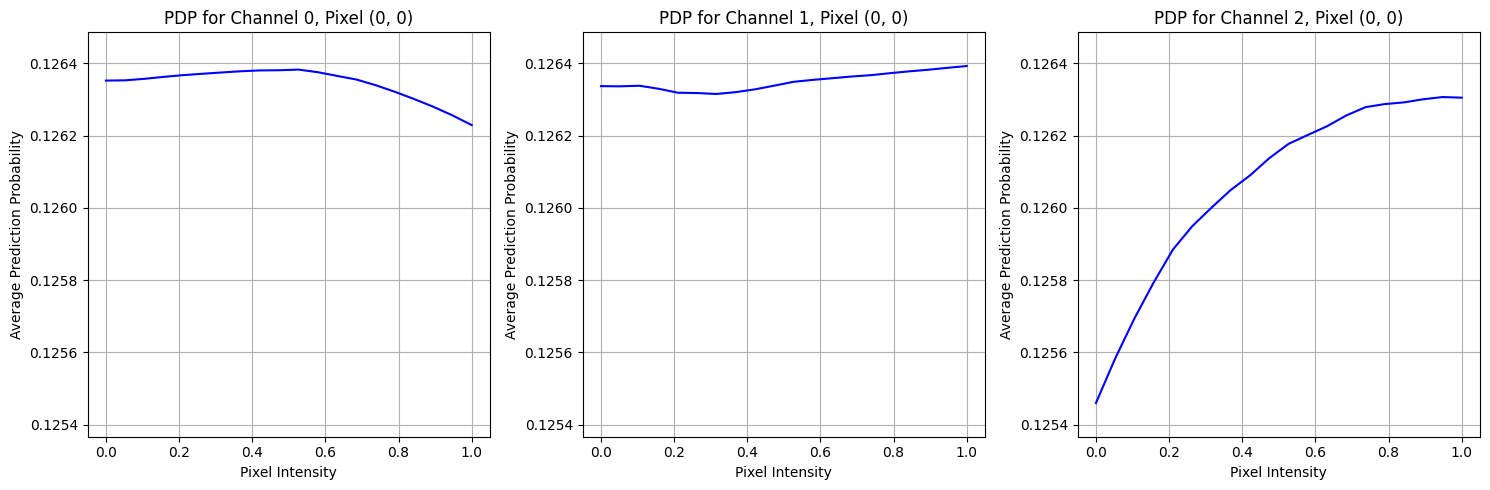

In [13]:
def create_pdp_plot(model, images, feature_indices=[0, 1, 2]):
    """
    Creates Partial Dependence Plots for image features, organized by color channels,
    with normalized y-axis scales.
    """
    # Prepare data
    X = images.numpy()
    batch_size, channels, height, width = X.shape

    # Define features from different channels
    channel_features = [
        0,
        height*width,
        2*height*width                                        #Modified from Claude AI at 7:47 pm 2/5/2025
    ]

    plt.figure(figsize=(15, 5))

    # Store all pdp values to find global min and max
    all_pdp_values = []

    # First pass to collect all PDP values
    for feature_idx in channel_features:
        channel = feature_idx // (height*width)
        pixel_pos = feature_idx % (height*width)

        feature_range = np.linspace(0, 1, num=20)
        pdp_values = []

        for value in feature_range:
            X_mod = X.copy()
            X_mod[:, channel, pixel_pos//width, pixel_pos%width] = value
            X_mod_tensor = torch.FloatTensor(X_mod)                        #Taken from Claude AI at 7:58 pm 2/5/2025

            with torch.no_grad():
                outputs = model(X_mod_tensor)
                probs = torch.softmax(outputs, dim=1)
                avg_prob = probs.mean(dim=0).max().item()
                pdp_values.append(avg_prob)                              #Modified from Claude AI at 8:04 pm 2/5/2025

        all_pdp_values.extend(pdp_values)

    # Get global min and max
    global_min = min(all_pdp_values)
    global_max = max(all_pdp_values)
    y_buffer = (global_max - global_min) * 0.1  # Add 10% buffer

    # Second pass to create plots with normalized scales
    for idx, feature_idx in enumerate(channel_features):
        channel = feature_idx // (height*width)
        pixel_pos = feature_idx % (height*width)

        feature_range = np.linspace(0, 1, num=20)
        pdp_values = []

        for value in feature_range:
            X_mod = X.copy()
            X_mod[:, channel, pixel_pos//width, pixel_pos%width] = value
            X_mod_tensor = torch.FloatTensor(X_mod)                         #Modified from Claude AI at 8:10 pm 2/5/2025

            with torch.no_grad():
                outputs = model(X_mod_tensor)
                probs = torch.softmax(outputs, dim=1)
                avg_prob = probs.mean(dim=0).max().item()
                pdp_values.append(avg_prob)                                 #Modified from Claude AI at 8:10 pm 2/5/2025

        plt.subplot(1, 3, idx + 1)
        plt.plot(feature_range, pdp_values, 'b-')
        plt.title(f'PDP for Channel {channel}, Pixel ({pixel_pos//width}, {pixel_pos%width})')
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Average Prediction Probability')
        plt.ylim(global_min - y_buffer, global_max + y_buffer)  # Set same y-axis limits
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call the function
create_pdp_plot(model, images)

#PDP Results and Interpretation

The PDP plots visualize how changes in pixel intensity across the first pixel position (0,0) affect the model's prediction probabilities for each color channel, where Channel 0 represents the red channel, Channel 1 represents the green channel, and Channel 2 represents the blue channel. The blue channel demonstrates the strongest relationship, showing a clear positive correlation where higher intensity values (particularly in the 0.2-0.8 range) lead to increased prediction probabilities, indicating this channel has the most significant impact on the model's decisions. The red channel shows a relatively stable response until around intensity 0.6, after which it exhibits a negative relationship, suggesting that high red values at this pixel position slightly decrease the model's prediction confidence. The green channel shows minimal variation in prediction probabilities across different intensity values, indicating it has the least influence on the model's predictions at this specific pixel location.



#Ice Plot Analysis

While PDPs show us average effects across all instances, ICE plots will let us see how individual images respond to changes in pixel intensity. By examining individual instances, we can better understand if our model's behavior is consistent across different images or if certain images show unique patterns. I'll analyze the same pixel position (0,0) across the three color channels to compare with our PDP results.

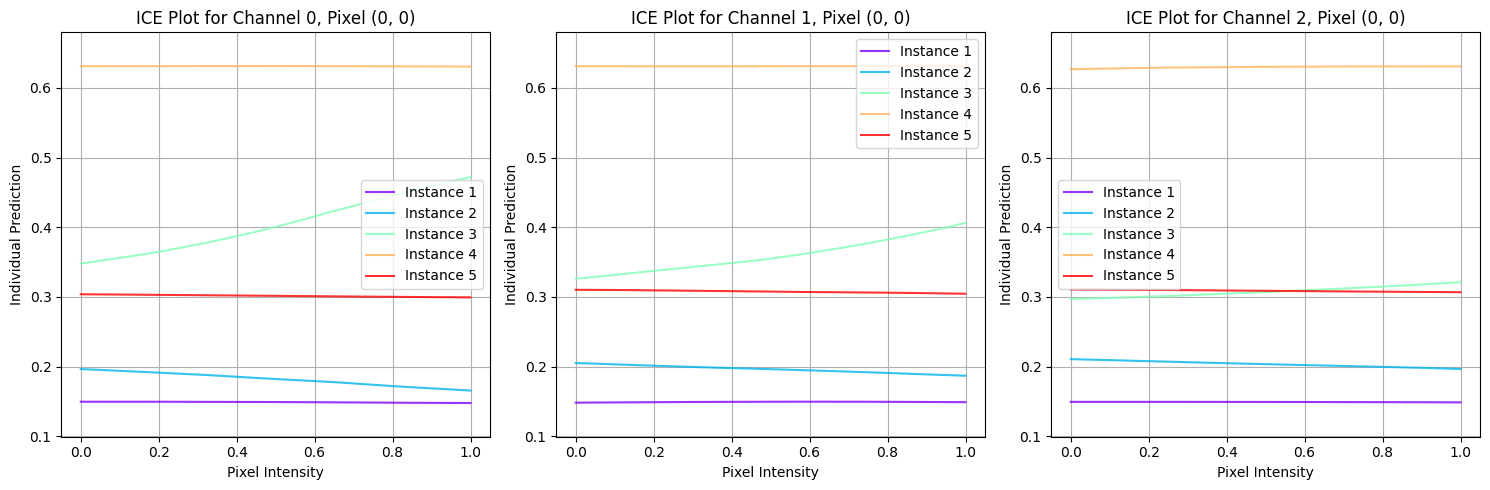

In [17]:
def create_ice_plot(model, images, feature_indices=[0, 1, 2], n_samples=5):
    """
    Creates Individual Conditional Expectation (ICE) plots for image features,
    organized by color channels.
    """
    # Prepare data
    X = images.numpy()
    batch_size, channels, height, width = X.shape

    # Define features from different channels
    channel_features = [
        0,              # First pixel of red channel
        height*width,   # First pixel of green channel
        2*height*width  # First pixel of blue channel
    ]

    plt.figure(figsize=(15, 5))
    colors = plt.cm.rainbow(np.linspace(0, 1, n_samples))

    # Store all ICE values for y-axis normalization
    all_ice_values = []

    # First pass to collect all values
    for feature_idx in channel_features:
        channel = feature_idx // (height*width)
        pixel_pos = feature_idx % (height*width)                               #Modified from Claude AI at 8:11 pm 2/5/2025

        feature_range = np.linspace(0, 1, num=20)

        for i in range(n_samples):
            ice_values = []
            X_mod = X[i:i+1].copy()

            for value in feature_range:
                X_mod_temp = X_mod.copy()
                X_mod_temp[0, channel, pixel_pos//width, pixel_pos%width] = value
                X_mod_tensor = torch.FloatTensor(X_mod_temp)

                with torch.no_grad():
                    outputs = model(X_mod_tensor)
                    pred_prob = torch.softmax(outputs, dim=1).max(dim=1)[0].item()
                ice_values.append(pred_prob)                                            #Modified from Claude AI at 8:20 pm 2/5/2025

            all_ice_values.extend(ice_values)

    # Get global min and max
    global_min = min(all_ice_values)
    global_max = max(all_ice_values)
    y_buffer = (global_max - global_min) * 0.1

    # Second pass to create plots
    for idx, feature_idx in enumerate(channel_features):
        channel = feature_idx // (height*width)
        pixel_pos = feature_idx % (height*width)

        feature_range = np.linspace(0, 1, num=20)
        plt.subplot(1, 3, idx + 1)

        for i, color in zip(range(n_samples), colors):
            ice_values = []
            X_mod = X[i:i+1].copy()

            for value in feature_range:
                X_mod_temp = X_mod.copy()
                X_mod_temp[0, channel, pixel_pos//width, pixel_pos%width] = value
                X_mod_tensor = torch.FloatTensor(X_mod_temp)                              #Modified from Claude AI at 8:28 pm 2/5/2025

                with torch.no_grad():
                    outputs = model(X_mod_tensor)
                    pred_prob = torch.softmax(outputs, dim=1).max(dim=1)[0].item()
                ice_values.append(pred_prob)

            plt.plot(feature_range, ice_values, color=color, alpha=0.8,
                    label=f'Instance {i+1}')

        plt.title(f'ICE Plot for Channel {channel}, Pixel ({pixel_pos//width}, {pixel_pos%width})')
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Individual Prediction')
        plt.ylim(global_min - y_buffer, global_max + y_buffer)
        plt.grid(True)
        plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function
create_ice_plot(model, images)

#ICE Plot Analysis and Findings

The ICE plots visualize how the model's predictions change for individual instances as we vary the pixel intensity at position (0,0) across the three color channels (Channel 0/red, Channel 1/green, and Channel 2/blue). The plots show five different instances, each represented by a different colored line, with prediction probabilities ranging from approximately 0.15 to 0.45, indicating significant variation in how the model responds to different images. While Instance 3 shows some positive correlation between pixel intensity and prediction probability across all channels, most other instances maintain relatively stable predictions regardless of pixel intensity changes. The consistency in relative positions of the instance lines across all three channels suggests that the model's behavior is stable across color channels, with instances that have higher predictions in one channel generally maintaining higher predictions in other channels as well. These individual-level insights complement our PDP plots by revealing that while aggregate trends might show certain patterns, individual instances can behave quite differently from the average.

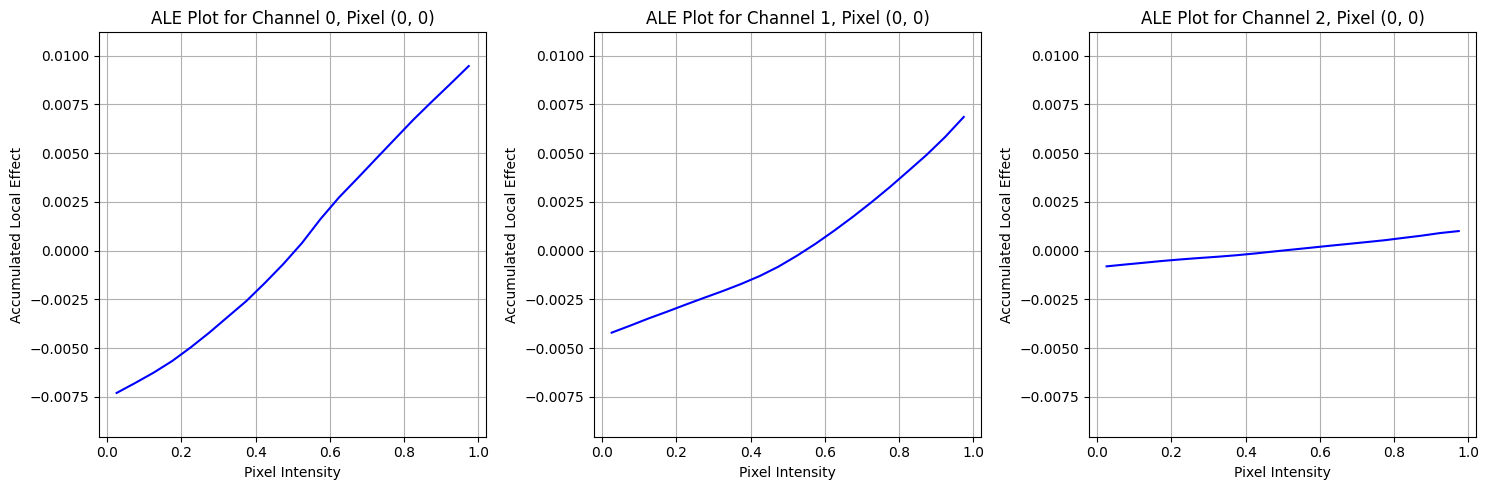

In [19]:
def create_ale_plot(model, images, feature_indices=[0, 1, 2]):
    """
    Creates Accumulated Local Effects (ALE) plots for image features,
    organized by color channels.
    """
    # Prepare data
    X = images.numpy()
    batch_size, channels, height, width = X.shape

    # Define features from different channels
    channel_features = [
        0,              # First pixel of red channel
        height*width,   # First pixel of green channel
        2*height*width  # First pixel of blue channel
    ]

    plt.figure(figsize=(15, 5))

    # Store all ALE values for y-axis normalization
    all_ale_values = []

    for idx, feature_idx in enumerate(channel_features):
        channel = feature_idx // (height*width)
        pixel_pos = feature_idx % (height*width)

        # Create bins for the feature
        n_bins = 20
        feature_range = np.linspace(0, 1, n_bins + 1)  # Using normalized pixel values

        ale_values = [0]  # Start at 0
        feature_values = []

        # Calculate ALE values
        for i in range(len(feature_range)-1):
            lower, upper = feature_range[i], feature_range[i+1]
            center = (lower + upper) / 2
            feature_values.append(center)                                   #Modified from Claude AI at 8:45 pm 2/5/2025

            effects = []
            for x_idx in range(batch_size):
                x = X[x_idx:x_idx+1].copy()

                # Calculate local effect
                x_lower = x.copy()
                x_upper = x.copy()
                x_lower[0, channel, pixel_pos//width, pixel_pos%width] = lower
                x_upper[0, channel, pixel_pos//width, pixel_pos%width] = upper

                with torch.no_grad():
                    pred_lower = model(torch.FloatTensor(x_lower))
                    pred_upper = model(torch.FloatTensor(x_upper))

                    effect = (torch.softmax(pred_upper, dim=1).max() -
                             torch.softmax(pred_lower, dim=1).max()).item()
                    effects.append(effect)

            ale_values.append(ale_values[-1] + np.mean(effects))          #Modified from Claude AI at 8:55 pm 2/5/2025

        # Center ALE values
        ale_values = np.array(ale_values)
        ale_values -= np.mean(ale_values)

        all_ale_values.extend(ale_values)

        plt.subplot(1, 3, idx + 1)
        plt.plot(feature_values, ale_values[1:], 'b-')
        plt.title(f'ALE Plot for Channel {channel}, Pixel ({pixel_pos//width}, {pixel_pos%width})')
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Accumulated Local Effect')
        plt.grid(True)

    # Set consistent y-axis limits
    y_min, y_max = min(all_ale_values), max(all_ale_values)
    y_buffer = (y_max - y_min) * 0.1

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.ylim(y_min - y_buffer, y_max + y_buffer)

    plt.tight_layout()
    plt.show()

# Call the function
create_ale_plot(model, images)

#ALE Plot Results and Explnation
The ALE plots visualize how changes in pixel intensity at position (0,0) affect the model's predictions across the three color channels (Channel 0/red, Channel 1/green, and Channel 2/blue), while accounting for feature interactions. The red channel demonstrates the strongest relationship, exhibiting a clear linear trend from negative effects at low intensities (-0.0075) to positive effects at high intensities (0.0100), indicating that changes in red intensity have the most substantial and consistent impact on the model's predictions. The Green Channel shows a similar but moderately weaker positive trend, ranging from -0.0050 to 0.0075, suggesting that green intensity values also progressively influence predictions but with less impact than the red channel. In contrast, the Blue Channel displays the weakest relationship with a very slight positive trend and much smaller effect magnitude (ranging from -0.0010 to 0.0010), indicating that blue intensity at this pixel position has minimal influence on the model's predictions when accounting for feature interactions.

#Conclusion and Final Analysis

The analysis of our ResNet34 model's behavior on CIFAR-10 images through various interpretability techniques reveals interesting insights about how different color channels at pixel position (0,0) influence the model's predictions. Let's examine each visualization method and their collective implications:

Feature Correlation Analysis:
The correlation heatmap reveals extremely high correlations (0.995-1.000) between the first 10 features of the flattened image data, which is expected since neighboring pixels often share similar values and patterns. Features 6-9 show particularly strong positive correlations with each other, while features 0-2 exhibit slightly weaker correlations with the other features. This strong correlation between features suggests potential interactions that might affect how we interpret the model's behavior.

PDP Plots:
The PDP plots demonstrate varying influences across color channels at pixel (0,0). The blue channel (Channel 2) shows the strongest relationship with a clear positive correlation, where higher intensity values lead to increased prediction probabilities. The red channel (Channel 0) maintains stable predictions until intensity 0.6, after which it shows a negative relationship. The green channel (Channel 1) exhibits minimal variation, suggesting the least influence on predictions at this position.

ICE Plots:
The ICE plots reveal significant variation in how individual instances respond to changes in pixel intensity, with prediction probabilities ranging from 0.15 to 0.45 across instances. While Instance 3 shows consistent positive correlation between pixel intensity and predictions across all channels, most other instances maintain relatively stable predictions.

ALE Plots:
The ALE plots, which account for feature interactions, present a notably different picture from the PDPs. Channel 0 (red) shows the strongest linear relationship, with effects ranging from -0.0075 to 0.0100, indicating substantial impact on predictions. Channel 1 (green) displays a moderately weaker but similar trend, while Channel 2 (blue) shows minimal influence - a striking contrast to its strong showing in the PDP analysis.

#Key Differences and Implications:
The most notable difference between PDP and ALE plots lies in their assessment of the blue channel's importance. While PDPs suggest the blue channel has the strongest influence, ALE plots indicate it has the least impact when accounting for feature interactions. This discrepancy can be attributed to the high feature correlations we observed in the heatmap, demonstrating the importance of considering feature interactions in image analysis.

The combination of these techniques provides a more complete understanding of our model's behavior. While individual techniques might suggest certain relationships (like the blue channel's importance in PDPs), the collective analysis reveals a more nuanced picture where the red channel appears to have the most consistent influence when accounting for feature interactions. This highlights the importance of using multiple interpretability techniques when analyzing complex models, especially in domains like image classification where feature interactions are prevalent.

These findings not only help us understand this specific model's behavior but also demonstrate how different interpretability techniques can provide complementary insights, sometimes challenging our initial assumptions about feature importance.